In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import pandas as pd
import PIL
import time
import os
from helper import get_car_paths, get_cars_df
from efficientnet_pytorch import EfficientNet
import random
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torch import nn
import torch.optim as optim

from fastai.vision import *

In [2]:
def seed_all(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

seed_all(seed=42)

In [3]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        print(m.weight)
    elif type(m) == nn.BatchNorm1d:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
        
def split_effnet(m):
    blocks_length = len(m._blocks)
    return ([m._conv_stem, m._bn0] + list(m._blocks.children())[:blocks_length//2], 
            list(m._blocks.children())[blocks_length//2:] + [m._conv_head, m._bn1],
            list(m.children())[5]
            )
def get_effnet(name="efficientnet-b0", pretrained=True, n_class=None):
    
    assert n_class != None, "Please specify the number of output classes `n_class`"
    
    if pretrained == True:
        print(f"Getting pretrained {name}")
        m = EfficientNet.from_pretrained(name)
    else:
        print(f"Getting random initialized {name}")
        m = EfficientNet.from_name(name)
    
    n_in = m._fc.in_features
    m._fc = nn.Sequential(
        nn.Dropout(p=0.5), 
        nn.Linear(n_in, n_class))
    m._fc.apply(init_weights)
    return m

def get_train_test_data(tfms=None, bs=32, sz=224, padding_mode='reflection', normalize=None):
    train_path, test_path = get_car_paths()
    train_df = get_cars_df('cars_train_annos.mat')
    test_df = get_cars_df('cars_test_annos_withlabels.mat')
    train_val_data = ImageDataBunch.from_df(train_path, train_df,
                                      ds_tfms=tfms, size=sz, fn_col=0, label_col=1, valid_pct=0.2, bs=bs, padding_mode=padding_mode)
    test_data = ImageDataBunch.from_df(test_path, test_df,
                                      ds_tfms=None, size=sz, fn_col=0, label_col=1, valid_pct=0., bs=bs, padding_mode=padding_mode)
    if normalize is not None:
        if normalize == "imagenet":
            train_val_data.normalize(imagenet_stats)
            test_data.normalize(imagenet_stats)
        elif normalize == "batch_stats":
            train_val_data.normalize()
            test_data.normalize(train_val_data.batch_stats)
        else:
            print("No normalization")
    return train_val_data, test_data

def get_learner(databunch, model, fp16=True):
    learn = Learner(databunch, model, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
    if fp16: learn.to_fp16()
    return learn

# Download and Untar Data

In [4]:
train_path, test_path = get_car_paths()
train_df = get_cars_df('cars_train_annos.mat')
test_df = get_cars_df('cars_test_annos_withlabels.mat')

# B3, size=300x300, 20 Epochs, normalize(imagenet_stats)

In [5]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

name 'learn' is not defined


In [6]:
tfms = get_transforms()
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=(300,300), normalize="imagenet")

In [10]:
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=196)
learn = get_learner(train_val_data, eff_net, fp16=True)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[ 0.0036,  0.0113,  0.0279,  ...,  0.0231, -0.0258, -0.0206],
        [-0.0325, -0.0087,  0.0006,  ..., -0.0435,  0.0108, -0.0030],
        [ 0.0416, -0.0010, -0.0384,  ...,  0.0164,  0.0056,  0.0534],
        ...,
        [-0.0491,  0.0066,  0.0417,  ..., -0.0047, -0.0481,  0.0211],
        [-0.0211,  0.0488, -0.0081,  ...,  0.0428, -0.0212,  0.0288],
        [-0.0225,  0.0208, -0.0377,  ..., -0.0118, -0.0290, -0.0037]],
       requires_grad=True)


epoch,train_loss,valid_loss,accuracy,time
0,5.076705,4.647521,0.123464,01:35
1,2.693317,1.924430,0.489558,01:36
2,1.645522,2.356622,0.436732,01:37
3,1.650899,3.283628,0.289312,01:38
4,1.500285,2.418230,0.424447,01:36
5,1.343168,2.673287,0.369165,01:38
6,1.153504,2.338114,0.436732,01:39
7,1.025597,3.413372,0.290541,01:35
8,0.899928,2.236967,0.467445,01:37
9,0.769692,1.819411,0.539926,01:37


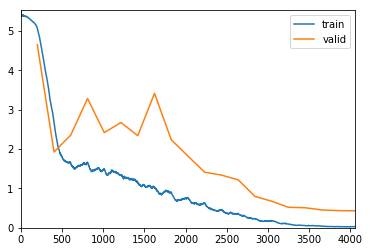

In [11]:
lr = 3e-3
wd = 1e-1
epochs = 20
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [12]:
learn.save("b3_sz300x300_20epochs_normal-imagenet")

# B3, size=300x300, 20 Epochs, normalize(imagenet_stats), zoom_crop

In [13]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

this Learner object self-destroyed - it still exists, but no longer usable


In [14]:
tfms = get_transforms(xtra_tfms=zoom_crop(scale=(0.75,2), do_rand=True))
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=(300,300), normalize="imagenet")

In [15]:
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=196)
learn = get_learner(train_val_data, eff_net, fp16=True)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[ 0.0178,  0.0437,  0.0047,  ..., -0.0637,  0.0454, -0.0054],
        [ 0.0510,  0.0463, -0.0109,  ..., -0.0373, -0.0324,  0.0469],
        [-0.0769,  0.0438, -0.0188,  ..., -0.0370, -0.0153, -0.0492],
        ...,
        [ 0.0292, -0.0003, -0.0333,  ...,  0.0025, -0.0236, -0.0471],
        [-0.0240, -0.0395,  0.0017,  ..., -0.0302, -0.0120,  0.0135],
        [-0.0413,  0.0344,  0.0430,  ..., -0.0167, -0.0475,  0.0610]],
       requires_grad=True)


epoch,train_loss,valid_loss,accuracy,time
0,5.106598,4.729920,0.100737,01:34
1,3.273760,2.394213,0.410934,01:34
2,2.169043,2.690168,0.356265,01:34
3,2.203341,2.849426,0.320639,01:34
4,2.212690,3.229796,0.277641,01:34
5,2.070830,2.715203,0.338452,01:34
6,1.844345,2.874846,0.313882,01:35
7,1.637539,2.358532,0.415848,01:34
8,1.381504,1.737738,0.549754,01:37
9,1.300062,1.946208,0.524570,01:35


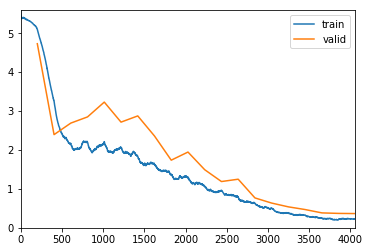

In [16]:
lr = 3e-3
wd = 1e-1
epochs = 20
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [17]:
learn.save("b3_sz300x300_20epochs_normal-imagenet_zoomcrop")

# B3, size=300, 20 Epochs, normalize(imagenet_stats), zoom_crop

In [5]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

name 'learn' is not defined


In [6]:
tfms = get_transforms(xtra_tfms=zoom_crop(scale=(0.75,2), do_rand=True))
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=300, normalize="imagenet")

In [7]:
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=196)
learn = get_learner(train_val_data, eff_net, fp16=True)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[ 0.0718, -0.0658, -0.0117,  ...,  0.0062,  0.0119,  0.0428],
        [ 0.0639, -0.0524, -0.0286,  ..., -0.0625,  0.0323, -0.0058],
        [ 0.0173,  0.0078, -0.0237,  ...,  0.0203, -0.0095,  0.0158],
        ...,
        [ 0.0250, -0.0226,  0.0317,  ...,  0.0056,  0.0121, -0.0259],
        [-0.0409,  0.0348,  0.0044,  ..., -0.0138, -0.0759, -0.0460],
        [-0.0812,  0.0199,  0.0363,  ..., -0.0296, -0.0574,  0.0551]],
       requires_grad=True)


epoch,train_loss,valid_loss,accuracy,time
0,5.162984,4.837645,0.092752,01:38
1,3.604719,2.849178,0.292998,01:36
2,2.599760,2.689834,0.338452,01:36
3,2.602536,3.171138,0.285012,01:37
4,2.445935,5.683571,0.203931,01:36
5,2.360094,3.398515,0.269656,01:36
6,2.098083,3.075146,0.277641,01:36
7,1.952321,2.017427,0.488329,01:36
8,1.693797,2.166955,0.441032,01:35
9,1.594281,1.539132,0.587224,01:37


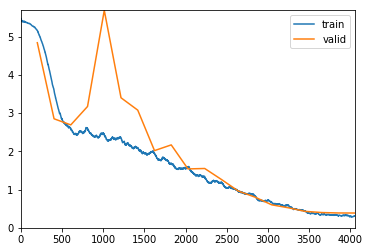

In [7]:
lr = 3e-3
wd = 1e-1
epochs = 20
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [8]:
learn.save("b3_sz300_20epochs_normal-imagenet_zoomcrop")

# B3, size=300, 20 Epochs, normalize(imagenet_stats), zoom_crop(scale=(0.75, 1.5)), cutout, wd=1e-5

In [5]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

name 'learn' is not defined


In [6]:
xtra_tfms = zoom_crop(scale=(0.75,1.5), do_rand=True) + [cutout(n_holes=(1,4), length=(10, 50), p=1.)]
tfms = get_transforms(xtra_tfms=xtra_tfms)
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=300, normalize="imagenet")

In [7]:
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=196)
learn = get_learner(train_val_data, eff_net, fp16=True)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[ 0.0718, -0.0658, -0.0117,  ...,  0.0062,  0.0119,  0.0428],
        [ 0.0639, -0.0524, -0.0286,  ..., -0.0625,  0.0323, -0.0058],
        [ 0.0173,  0.0078, -0.0237,  ...,  0.0203, -0.0095,  0.0158],
        ...,
        [ 0.0250, -0.0226,  0.0317,  ...,  0.0056,  0.0121, -0.0259],
        [-0.0409,  0.0348,  0.0044,  ..., -0.0138, -0.0759, -0.0460],
        [-0.0812,  0.0199,  0.0363,  ..., -0.0296, -0.0574,  0.0551]],
       requires_grad=True)


epoch,train_loss,valid_loss,accuracy,time
0,5.138037,4.810350,0.085995,01:39
1,3.428549,2.572322,0.369165,01:36
2,2.292538,2.466713,0.393120,01:37
3,2.148556,2.913030,0.370393,01:36
4,1.991544,2.971869,0.343980,01:36
5,1.879934,1.947132,0.504914,01:36
6,1.605572,2.170291,0.474201,01:36
7,1.352616,1.413570,0.655405,01:36
8,1.168514,1.653884,0.608722,01:36
9,1.035978,1.145420,0.689189,01:36


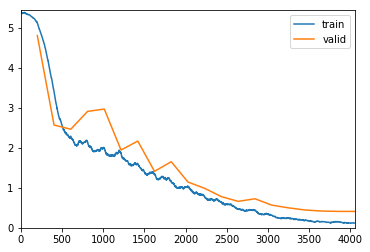

In [8]:
lr = 3e-3
wd = 1e-5
epochs = 20
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [ ]:
learn.save("b3_sz300_20epochs_normal-imagenet_zoomcrop")

# B3, size=300, 20 Epochs, normalize(imagenet_stats), rand_resize_crop

In [6]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

name 'learn' is not defined


In [7]:
tfms = get_transforms(xtra_tfms=rand_resize_crop(300, max_scale=2.0, ratios=(0.75, 1.33)))
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=300, normalize="imagenet")

In [8]:
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=196)
learn = get_learner(train_val_data, eff_net, fp16=True)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[-0.0536, -0.0216,  0.0016,  ...,  0.0020,  0.0500,  0.0447],
        [-0.0192,  0.0428, -0.0357,  ...,  0.0522,  0.0246, -0.0467],
        [-0.0081,  0.0245, -0.0039,  ..., -0.0337, -0.0430, -0.0109],
        ...,
        [-0.0181,  0.0115,  0.0129,  ..., -0.0099,  0.0221, -0.0353],
        [-0.1010,  0.0380, -0.0561,  ...,  0.0691, -0.0047, -0.0425],
        [ 0.0142,  0.0740, -0.0543,  ...,  0.0185,  0.0211,  0.0200]],
       requires_grad=True)


epoch,train_loss,valid_loss,accuracy,time
0,5.078391,4.733749,0.097052,01:38
1,3.128467,2.471825,0.355651,01:37
2,2.065155,2.358328,0.408477,01:38
3,1.978597,3.256512,0.335995,01:38
4,1.908676,3.244434,0.273956,01:36
5,1.779976,2.793937,0.340295,01:37
6,1.498640,2.475498,0.382678,01:40
7,1.409567,2.404403,0.409091,01:39
8,1.220254,2.033123,0.486486,01:39
9,1.017412,1.934685,0.509828,01:39


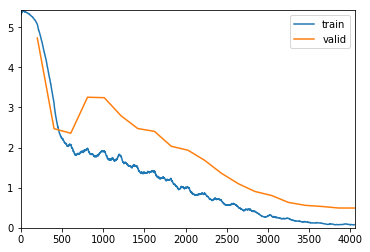

In [9]:
lr = 3e-3
wd = 1e-1
epochs = 20
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [8]:
learn.save("b3_sz300_20epochs_normal-imagenet_rand_resize_crop")

# B3, sz=300, 20 Epochs, zoom_crop

In [4]:
try:
    learn.destroy()
    del learn
    gc.collect()
except Exception as e:
    print(e)

name 'learn' is not defined


In [40]:
tfms = get_transforms(xtra_tfms=zoom_crop(scale=(0.75,2), do_rand=True))
train_val_data, _ = get_train_test_data(tfms=tfms, bs=32, sz=300, padding_mode="zeros")

In [42]:
n_class = 196
eff_net = get_effnet(name="efficientnet-b3", pretrained=True, n_class=n_class)

Getting pretrained efficientnet-b3
Loaded pretrained weights for efficientnet-b3
Parameter containing:
tensor([[-0.0072,  0.0721,  0.0491,  ..., -0.0071, -0.0148, -0.0271],
        [ 0.0085, -0.0438, -0.0097,  ..., -0.0791,  0.0018, -0.0702],
        [-0.0053, -0.0196, -0.0301,  ..., -0.0590,  0.0147, -0.1202],
        ...,
        [-0.0343,  0.0291,  0.0106,  ...,  0.0156,  0.0454,  0.0590],
        [-0.0174,  0.0005, -0.0278,  ...,  0.0194,  0.0529,  0.0159],
        [ 0.0051, -0.0319, -0.0159,  ..., -0.0302,  0.0350,  0.0167]],
       requires_grad=True)


In [44]:
learn = Learner(train_val_data, eff_net, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy], path='.', callback_fns=ShowGraph)
learn.to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: Data/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
Lamborghini Aventador Coupe 2012,Suzuki Aerio Sedan 2007,Suzuki Kizashi Sedan 2012,Dodge Caliber Wagon 2012,BMW 3 Series Sedan 2012
Path: Data/cars_train;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dSamePadding(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dSamePadding(40, 40, kernel_size

epoch,train_loss,valid_loss,accuracy,time
0,5.165739,4.860180,0.076167,01:36
1,3.711944,2.759920,0.316339,01:34
2,2.729475,2.587435,0.358108,01:35
3,2.593584,3.182458,0.264742,01:35
4,2.458220,2.724496,0.351351,01:35
5,2.349305,2.797056,0.315725,01:35
6,2.177639,3.441000,0.233415,01:35
7,1.949889,2.396260,0.385135,01:35
8,1.753502,2.141473,0.454545,01:35
9,1.546982,1.884265,0.498157,01:37


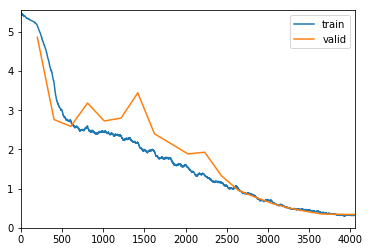

In [45]:
lr = 3e-3
wd = 1e-1
epochs = 20
learn.fit_one_cycle(epochs, max_lr=lr, wd=wd)

In [ ]:
learn.save("b3_sz300_20epochs_zoomcrop")

# fin